In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Data Exploration

In [4]:
df.info

<bound method DataFrame.info of             id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
...        ...     ...     ...   
404285  404285  433578  379845   
404286  404286   18840  155606   
404287  404287  537928  537929   
404288  404288  537930  537931   
404289  404289  537932  537933   

                                                question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
...                                                   ...   
404285  How many keywords are there in the Racket prog...   
404286          Do you believe there is life after death?   
404287    

<AxesSubplot: xlabel='is_duplicate'>

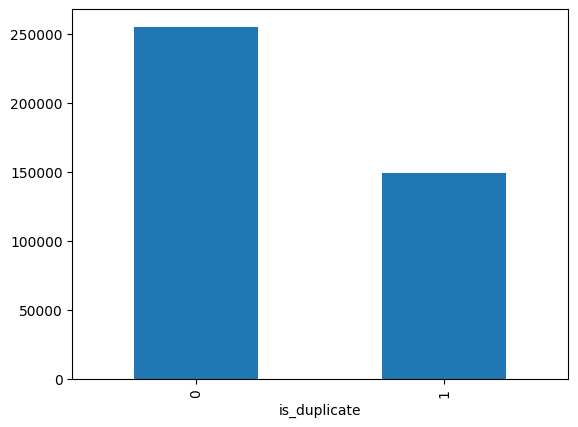

In [5]:
import matplotlib as plt
df.groupby("is_duplicate")["id"].count().plot.bar()

In [6]:
print("% of Non Duplicate Question Pairs = ", df[df['is_duplicate'] == 0].size/df.size*100)
print("% of Duplicate Question Pairs", df[df['is_duplicate'] == 1].size/df.size*100)

% of Non Duplicate Question Pairs =  63.08021469737069
% of Duplicate Question Pairs 36.9197853026293


In [7]:
import numpy as np
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = qids.unique()
qids_morethan_once = np.sum(qids.value_counts()>1)

print("Number of unique questions = ", len(unique_qids))
print("Number of unique questions that appear more than once = ", np.sum(qids.value_counts() > 1),"which is", np.sum(qids.value_counts() > 1)/len(unique_qids)*100, "%" )
print("Max appearances of a question = ", np.max(qids.value_counts()))

Number of unique questions =  537933
Number of unique questions that appear more than once =  111780 which is 20.77953945937505 %
Max appearances of a question =  157


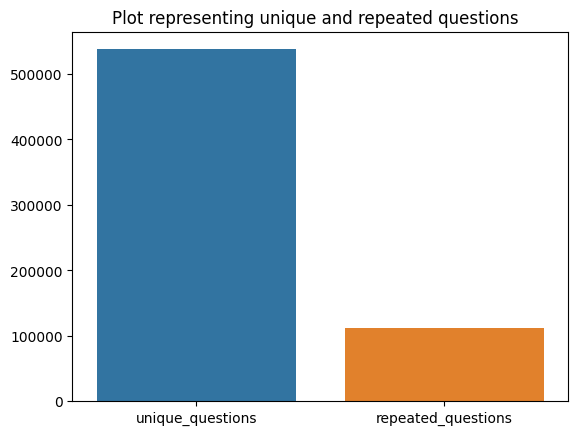

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
x = ['unique_questions', 'repeated_questions']
y = [len(unique_qids), qids_morethan_once]

plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(data = None, x = x, y = y)
plt.show()

In [9]:
# check for duplicate pairs
duplicate_pairs = df[['qid1','qid2','is_duplicate']].groupby(['qid1', 'qid2']).count()
duplicate_pairs[duplicate_pairs['is_duplicate']>1]

,,is_duplicate
qid1,qid2,


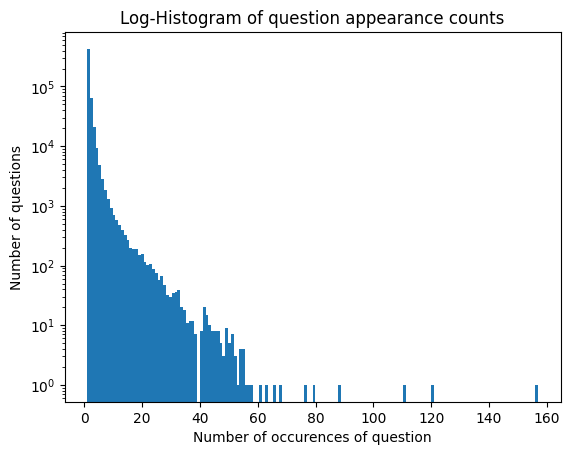

In [19]:
#hist plot 

plt.hist(qids.value_counts(), bins = 160) # use bins of width 20 to see exponential distribution, else it is not so clear
plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')
plt.show()

In [ ]:
# The distribution is exponential and most of the questions appear less than 40 times

In [11]:
# Dealing with NULLs
df[df.isnull().any(axis = 1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [12]:
df = df.fillna('')
df[df.isnull().any(axis = 1)]

,id,qid1,qid2,question1,question2,is_duplicate


### Feature Extraction

In [22]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row : len(str(row).split(' ')))
df['q2_n_words'] = df['question2'].apply(lambda row : len(str(row).split(' ')))

# number of common unique words in question1 and question2
def normalized_word_Common(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ") ))
    return len(w1&w2) # return length of intersection of 2 sets

df['word_Common'] = df.apply(normalized_word_Common, axis = 1) # because we want to select row by row

# total number of (not necessarily unique) words in question 1 and question 2

def normalized_word_Total(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    #return (len(w1) + len(w2))
    return len(w1.union(w2)) #returns unique total words

df['word_Total'] = df.apply(normalized_word_Total, axis = 1)

def normalized_word_share(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" "))) 
    return len(w1&w2)/len(w1.union(w2))

df['word_share'] = df.apply(normalized_word_share, axis = 1)

df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,13,0.769231,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,16,0.250000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,20,0.200000,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,18,0.111111,4,2


In [28]:
df['word_share'].head()

0    0.769231
1    0.250000
2    0.200000
3    0.000000
4    0.111111
Name: word_share, dtype: float64

<AxesSubplot: xlabel='is_duplicate', ylabel='word_share'>

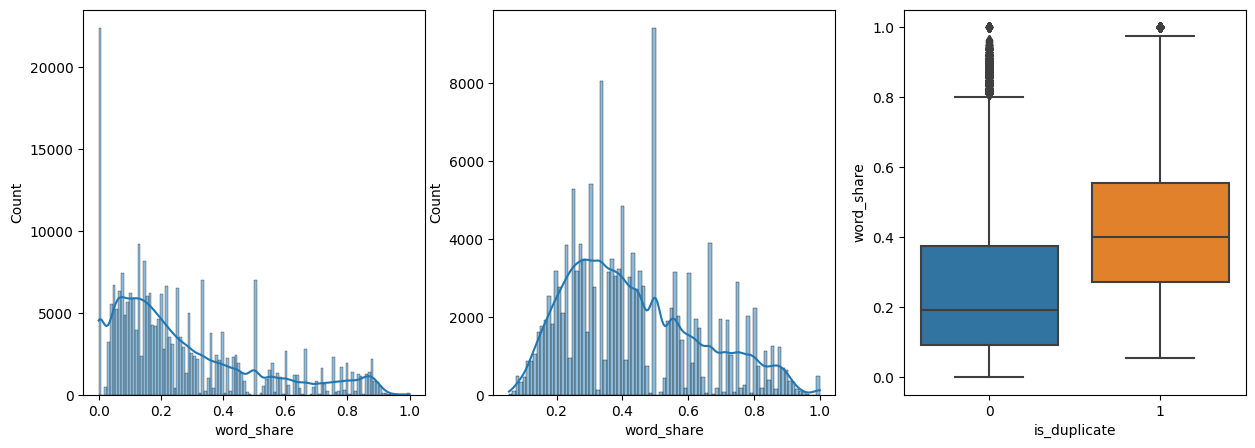

In [41]:
# Let's analyse wordshare
fig, axes = plt.subplots(1,3, figsize = (15,5))
sns.histplot(df[df['is_duplicate']==0]['word_share'], kde = True, ax = axes[0])
sns.histplot(df[df['is_duplicate']==1]['word_share'], kde = True, ax = axes[1])
sns.boxplot(data = df, x = df['is_duplicate'], y = df['word_share'], ax = axes[2])

C:\Users\aswat\AppData\Local\Temp\ipykernel_808\1973332811.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.distplot(df[df['is_duplicate'] == 1]['word_share'][0:] , label = "1", color = 'red')
C:\Users\aswat\AppData\Local\Temp\ipykernel_808\1973332811.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['word_share'][0:] , label = "1", color = 'red')
C:\

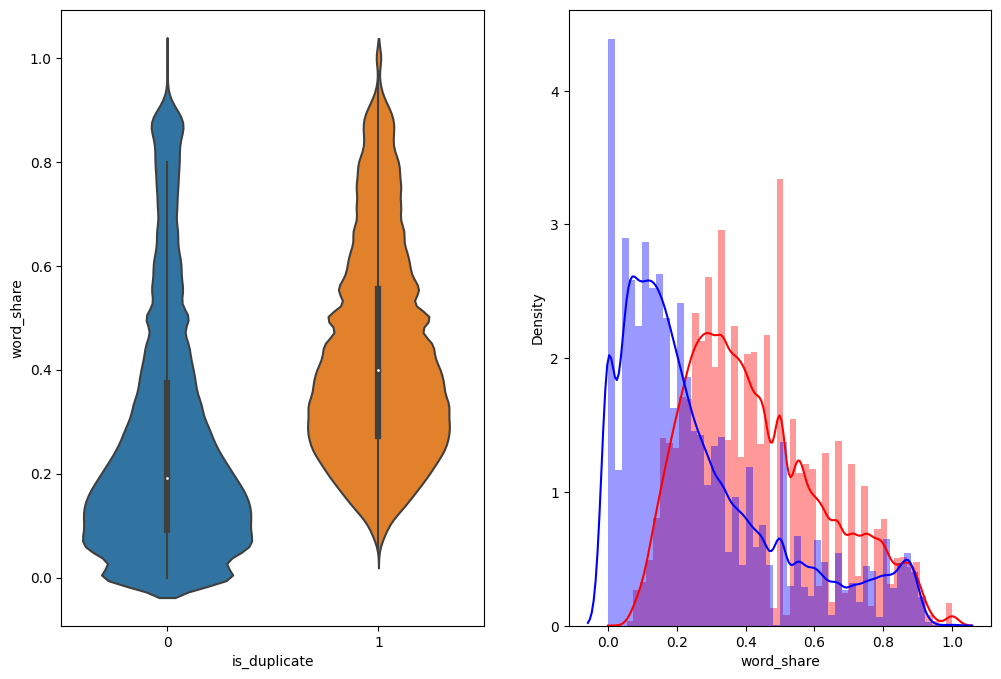

In [45]:
# combining above plots in a violin plot
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

##### observations:
##### 1. high word similarities in case of duplicate questions
##### 2. non duplicates and duplicates have higher similarity in right side of distribution; which means there are many questions
##### with similarities irrespective of if they are duplicates or not

<AxesSubplot: xlabel='word_Common', ylabel='Count'>

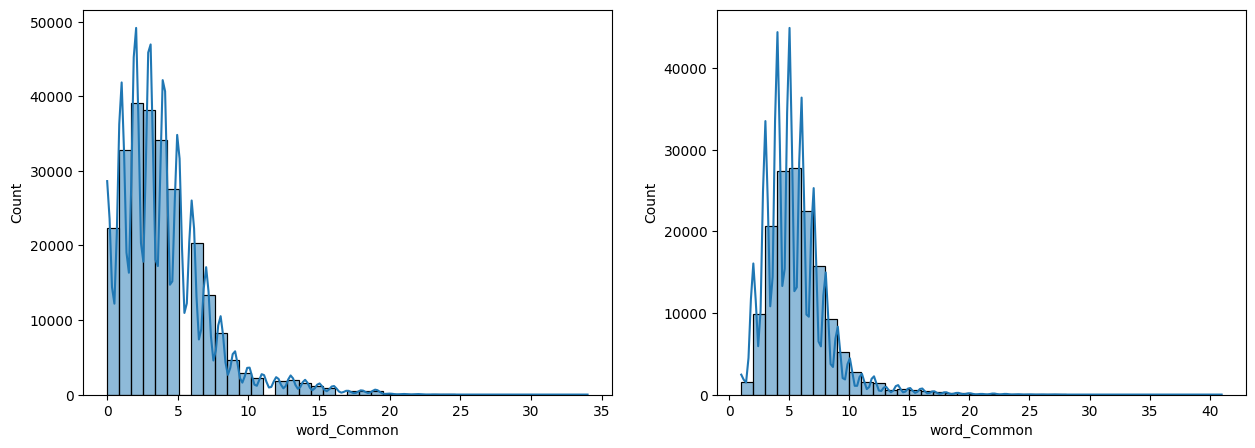

In [56]:
# distribution of common words count
fig, axes = plt.subplots(1,2, figsize = (15,5))
sns.histplot(data = df, x = df[df['is_duplicate']==0]['word_Common'], bins = 40, kde =True, ax = axes[0])
sns.histplot(data = df, x = df[df['is_duplicate']==1]['word_Common'], bins = 40, kde = True, ax = axes[1])

C:\Users\aswat\AppData\Local\Temp\ipykernel_808\3091341030.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
C:\Users\aswat\AppData\Local\Temp\ipykernel_808\3091341030.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red

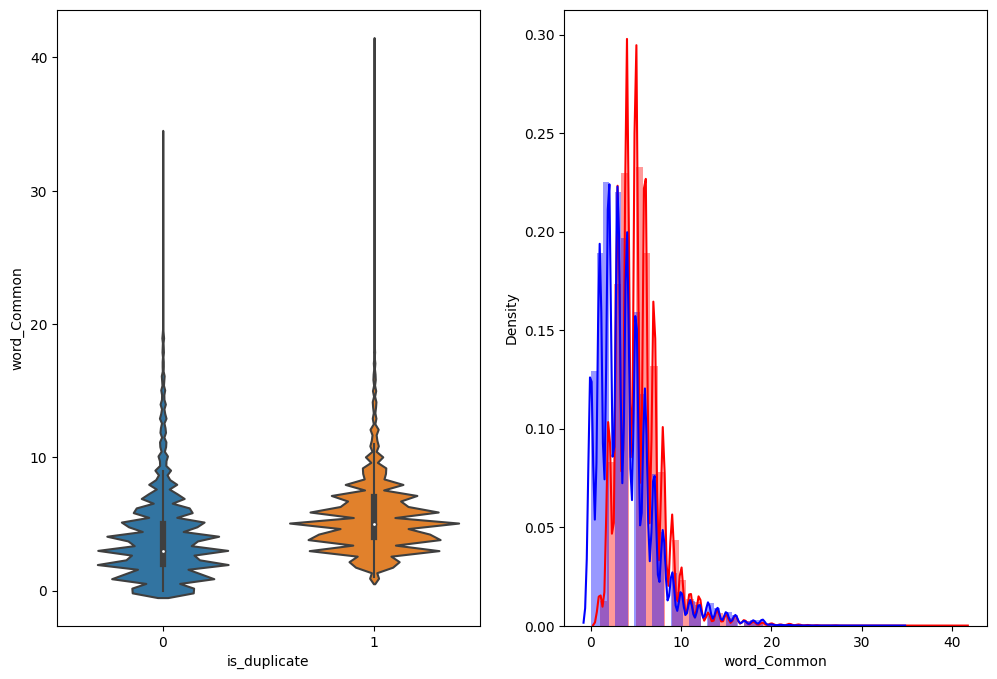

In [57]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [ ]:
# There is lot of overlap between common words count in duplicate and non duplicate sections.
# Hence this feature is not useful